In [1]:
import tensorflow as tf
from tensorflow import keras

/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dlopez/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
from skimage import measure
from scipy import ndimage
import matplotlib.pyplot as plt

def mask(img):
    contours = measure.find_contours(img, 0.5)
    
    if len(contours) == 0:
        return np.zeros_like(img, dtype='bool')
    elif len(contours) == 1:
        return np.zeros_like(img, dtype='bool')
    else:
        contours = contours[1:]
    r_mask = np.zeros_like(img, dtype='bool')
    for contour in contours:
        
        r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

        # Fill in the hole created by the contour boundary
        r_mask = ndimage.binary_fill_holes(r_mask)
    return r_mask

In [3]:
(X_train, Y_train), (X_test, Y_test) =  keras.datasets.mnist.load_data()

X_train = X_train/255
X_train = X_train > 0.5
#X_train = X_train[(Y_train==0) | (Y_train==8)]

Y_train = np.asarray([mask(img) for img in X_train]).astype(np.float32)

In [4]:
X_train = np.expand_dims(X_train, axis=3)
Y_train = np.expand_dims(Y_train, axis=3)

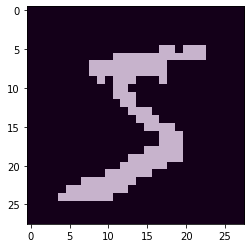

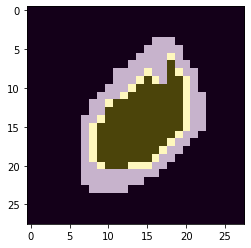

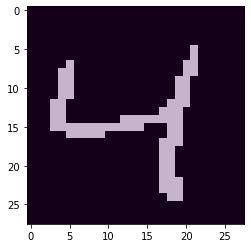

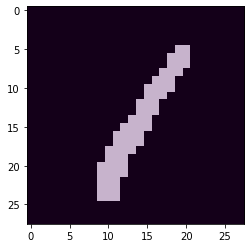

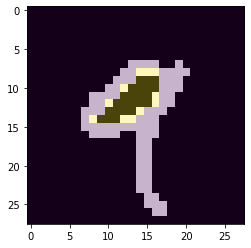

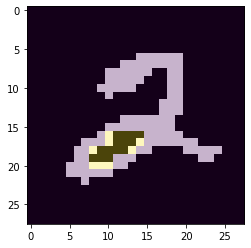

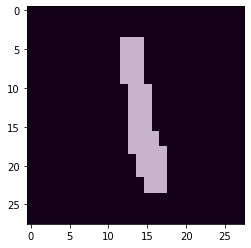

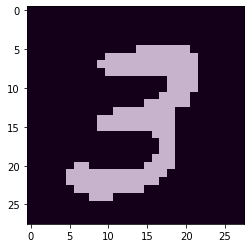

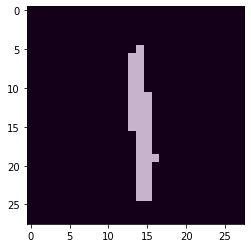

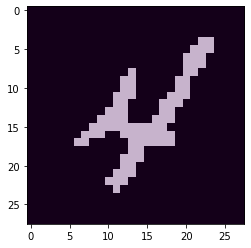

In [5]:
for i in range(10):
    plt.imshow(X_train[i,:,:,0], cmap="gray")
    plt.imshow(Y_train[i,:,:,0], alpha=0.3)
    plt.show()

In [26]:
input = keras.layers.Input((28,28,1))                                             # (None, 28, 28,  1)

conv1 = keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(input)  # (None, 28, 28, 16)
maxp1 = keras.layers.MaxPool2D((2,2))(conv1)                                      # (None, 14, 14, 16)

conv2 = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(maxp1)  # (None, 14, 14, 32)
maxp2 = keras.layers.MaxPool2D((2,2))(conv2)                                      # (None,  7,  7, 32)
 
conv3 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(maxp2)  # (None,  7,  7, 64)
maxp3 = keras.layers.MaxPool2D((2,2))(conv3)                                      # (None,  3,  3, 64)

tconv4 = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2),                       
                                      padding="valid", activation="relu")(maxp3)  # (None,  7,  7, 64)
con4 = keras.layers.concatenate([tconv4, conv3], axis=3)                          # (None,  7,  7, 128)

tconv5 = keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con4)    # (None, 14, 14, 32)
con5 = keras.layers.concatenate([tconv5, conv2], axis=3)                          # (None, 14, 14, 64)

tconv6 = keras.layers.Conv2DTranspose(16, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con5)    # (None, 28, 28, 16)
con6 = keras.layers.concatenate([tconv6, conv1], axis=3)                          # (None, 28, 28, 32)

conv7 = keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(con6) # (None, 28, 28, 1)

model = keras.models.Model(input, conv7)

In [27]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 28, 28, 16)   160         input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 14, 14, 16)   0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 14, 14, 32)   4640        max_pooling2d_39[0][0]           
____________________________________________________________________________________________

In [28]:
model.compile("adam", "binary_crossentropy")

In [29]:
model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
60000/60000 [==============================] - 24s 394us/sample - loss: 0.0796
Epoch 2/10
45696/60000 [=====================>........] - ETA: 5s - loss: 0.0395

KeyboardInterrupt: 

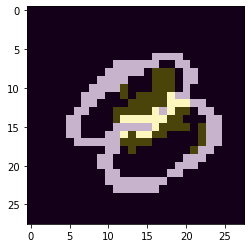

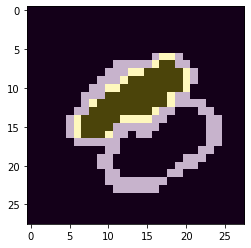

In [74]:
import matplotlib.pyplot as plt
idx = np.random.randint(X_train.shape[0])
plt.imshow(X_train[idx,:,:,0], cmap="gray")
plt.imshow(model.predict(X_train[idx:idx+1,:,:,:])[0,:,:,0]>0.5, alpha=0.3)
plt.show()
plt.imshow(X_train[idx,:,:,0], cmap="gray")
plt.imshow(Y_train[idx,:,:,0], alpha=0.3)